In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import time
import tqdm
from datetime import datetime
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18
genesis = 1606824023

In [42]:
stakers = pd.read_parquet('stakers.parquet.gzip')

In [23]:
delivered = pd.read_csv('delivered24.txt', delimiter='|', 
                        names=['signed_at','inserted_at','proposer_fee_recipient','proposer_pubkey','slot'])
delivered['signed_at'] = pd.to_datetime(delivered['signed_at'], format="%Y-%m-%d%H:%M:%S.%f")
delivered['inserted_at'] = pd.to_datetime(delivered['inserted_at'], format="%Y-%m-%d%H:%M:%S.%f")
delivered['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S')-pd.Timedelta(seconds=1)
                                         for x in delivered['signed_at'].values])
delivered['diff'] = [v.total_seconds() for v in delivered['signed_at']-delivered['slot_boundary']]

delivered.head()

,signed_at,inserted_at,proposer_fee_recipient,proposer_pubkey,slot,slot_boundary,diff
0,2023-04-06 12:13:59.684712,2023-04-06 12:14:00.989273,0xffee087852cb4898e6c3532e776e68bc68b1143b,0x8aa08624111e95b8ff3c5ea27129e791f8be18e98f95...,6163268,2023-04-06 12:13:59,0.684712
1,2023-04-06 12:14:23.724199,2023-04-06 12:14:25.068471,0xebec795c9c8bbd61ffc14a6662944748f299cacf,0x856fe483c902592f23bc0b90b16975e224e2354332a7...,6163270,2023-04-06 12:14:23,0.724199
2,2023-04-06 12:15:47.822904,2023-04-06 12:15:49.173361,0xffee087852cb4898e6c3532e776e68bc68b1143b,0x80d1862cce3979eedb809de383a630ce225c96509127...,6163277,2023-04-06 12:15:47,0.822904
3,2023-04-06 12:17:24.791384,2023-04-06 12:17:27.006807,0xebec795c9c8bbd61ffc14a6662944748f299cacf,0xb379cadcf137a1dd500f7ba64e8f22f834398dfe05c7...,6163285,2023-04-06 12:17:23,1.791384
4,2023-04-06 12:18:35.976799,2023-04-06 12:18:37.356851,0x388c818ca8b9251b393131c08a736a67ccb19297,0xaac4ffd599340ab2d8ac038156126f4f9aca3bfa7911...,6163291,2023-04-06 12:18:35,0.976799


In [31]:
delivered[['signed_at','slot_boundary', 'diff']]

,signed_at,slot_boundary,diff
0,2023-04-06 12:13:59.684712,2023-04-06 12:13:59,0.684712
1,2023-04-06 12:14:23.724199,2023-04-06 12:14:23,0.724199
2,2023-04-06 12:15:47.822904,2023-04-06 12:15:47,0.822904
3,2023-04-06 12:17:24.791384,2023-04-06 12:17:23,1.791384
4,2023-04-06 12:18:35.976799,2023-04-06 12:18:35,0.976799
...,...,...,...
2670,2023-04-07 12:14:47.715672,2023-04-07 12:14:47,0.715672
2671,2023-04-07 12:14:59.817935,2023-04-07 12:14:59,0.817935
2672,2023-04-07 12:15:47.580455,2023-04-07 12:15:47,0.580455
2673,2023-04-07 12:16:12.555995,2023-04-07 12:16:11,1.555995


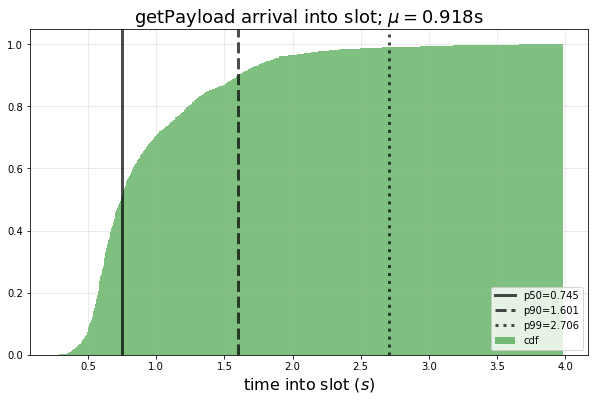

In [33]:
f, ax = plt.subplots(figsize=(10,6))

bins = np.histogram(delivered['diff'], bins=600)[1]

ax.hist(delivered['diff'], bins, color='g', alpha=0.5, cumulative=1, density=True, label='cdf')
percs = [(int(i*100), np.quantile(delivered['diff'], i)) for i in [.50, .90, .99]]
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.3f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)

ax.set_xlabel('time into slot $(s)$', size=16)
ax.set_title('getPayload arrival into slot; $\mu={:0.3f}$s'.format(delivered['diff'].mean()), size=18)
plt.legend(loc=4)
plt.show()

In [34]:
lateish = delivered[delivered['diff'] >= 2]
lateish

,signed_at,inserted_at,proposer_fee_recipient,proposer_pubkey,slot,slot_boundary,diff
6,2023-04-06 12:19:37.708393,2023-04-06 12:19:39.312535,0x4675c7e5baafbffbca748158becba61ef3b0a263,0xac7564cc41026f2e5e267dc88ac10e9ba45bd360a6dc...,6163296,2023-04-06 12:19:35,2.708393
30,2023-04-06 12:30:26.485719,2023-04-06 12:30:27.961698,0x388c818ca8b9251b393131c08a736a67ccb19297,0x91da2ba76af5228c0a8fa702f530b839609ac4ee853f...,6163350,2023-04-06 12:30:23,3.485719
36,2023-04-06 12:32:25.153372,2023-04-06 12:32:26.760679,0xebec795c9c8bbd61ffc14a6662944748f299cacf,0x80883208b47d370a1e60b95d4e6b280ca576767d2ebb...,6163360,2023-04-06 12:32:23,2.153372
66,2023-04-06 12:47:25.537436,2023-04-06 12:47:26.840860,0x4675c7e5baafbffbca748158becba61ef3b0a263,0x908c3f20bcfaa86fa727272769552372671d4fb3f565...,6163435,2023-04-06 12:47:23,2.537436
74,2023-04-06 12:50:13.480466,2023-04-06 12:50:14.808521,0x90b0c836a19a74195d45fad2d2d3895a7a3eab08,0xaf9f39f7fbdf879f6967171bbb4ad82448c3c5a339c7...,6163449,2023-04-06 12:50:11,2.480466
...,...,...,...,...,...,...,...
2560,2023-04-07 11:20:01.172694,2023-04-07 11:20:03.364819,0x1d15a60073b81e658e40bcc500be409d581927d7,0x81847df5fa3a39109a8a756835312955b0c23f42f195...,6170198,2023-04-07 11:19:59,2.172694
2563,2023-04-07 11:22:01.938405,2023-04-07 11:22:03.708464,0x4675c7e5baafbffbca748158becba61ef3b0a263,0xa0715286b27cfb29ad8f2ce0338d6398f267b4efceb3...,6170208,2023-04-07 11:21:59,2.938405
2605,2023-04-07 11:41:13.815484,2023-04-07 11:41:15.399621,0x6d2e03b7effeae98bd302a9f836d0d6ab0002766,0x96843477b6bbdb244a96dc32f0484d3a41036d183574...,6170304,2023-04-07 11:41:11,2.815484
2637,2023-04-07 11:57:01.196228,2023-04-07 11:57:02.601597,0x4675c7e5baafbffbca748158becba61ef3b0a263,0x9072cf61b03b729d9c6ab83d59001ff93d963ffe1458...,6170383,2023-04-07 11:56:59,2.196228


In [36]:
lateish['proposer_fee_recipient'].value_counts()

0x4675c7e5baafbffbca748158becba61ef3b0a263    26
0x388c818ca8b9251b393131c08a736a67ccb19297    23
0xebec795c9c8bbd61ffc14a6662944748f299cacf    12
0x6d2e03b7effeae98bd302a9f836d0d6ab0002766     4
0xe94f1fa4f27d9d288ffea234bb62e1fbc086ca0c     3
0xf8636377b7a998b51a3cf2bd711b870b3ab0ad56     2
0x91da5bf3f8eb72724e6f50ec6c3d199c6355c59c     2
0xd4e96ef8eee8678dbff4d535e033ed1a4f7605b7     2
0x07f20b1265059feb39d605e8476aa51595483ec6     2
0x3bdea606effc7ba0f50ebaa2bac328dccc08d37f     1
0x0038598ecb3b308ebc6c6e2c635bacaa3c5298a3     1
0x4c992ec2d310ad988ed4b6874f6c3ca129358cfa     1
0x87129f59a6b09b83a2695c8aa7d96540b74826ab     1
0x0dd1607e8c911e07f29f23bad8cd22b2a3df9785     1
0xf7c2aea111990e706c34444c32687243b90dad9e     1
0x9695ee4778bdeb13b217979d93c4670cbf41cc65     1
0x87d92cb7d006f82ea05c70d20b2fcce501a8c1b0     1
0xab6b4b11378a57933333e4acfdc45567dd78f14e     1
0xca9152c5bdcc094f3f7defbba803c92931cad4ba     1
0x115b5736b5afcc6deca11cd13a85cae887887c89     1
0x1d15a60073b81e658e

In [43]:
stakers[stakers['pubkey']=='0xac7564cc41026f2e5e267dc88ac10e9ba45bd360a6dc00079254f2a6ae01fefa71d893c67c3103922a57f5baf5fd0f9d']

,pubkey,address,label
301705,0xac7564cc41026f2e5e267dc88ac10e9ba45bd360a6dc...,0x8d0f588e3fd89ec1f75a923eac169bc191e18531,coinbase


In [57]:
stakers_count = {}
for pk in lateish['proposer_pubkey']:
    entry = stakers[stakers['pubkey']==pk]
    if len(entry) == 1:
        try: 
            stakers_count[entry['label'].values[0]] += 1
        except KeyError:
            stakers_count[entry['label'].values[0]] = 1
    else:
        try: 
            stakers_count['unknown'] += 1
        except KeyError:
            stakers_count['unknown'] = 1
#         print(entry)

In [59]:
dict(sorted(stakers_count.items(), key=lambda item: item[1], reverse=True))

{'coinbase': 22,
 'lido': 22,
 'unknown': 20,
 'kraken': 12,
 'stakefish': 7,
 'bitcoin suisse': 4,
 'huobi': 2,
 'stkr': 1,
 'rocketpool': 1,
 'poloniex': 1,
 'stakehound': 1,
 'staked.us': 1}

In [60]:
notlate = delivered[delivered['diff'] < 2]

In [66]:
stakers_count = {}
for pk in tqdm.tqdm(notlate['proposer_pubkey']):
    entry = stakers[stakers['pubkey']==pk]
    if len(entry) == 1:
        try: 
            stakers_count[entry['label'].values[0]] += 1
        except KeyError:
            stakers_count[entry['label'].values[0]] = 1
    else:
        try: 
            stakers_count['unknown'] += 1
        except KeyError:
            stakers_count['unknown'] = 1
#         print(entry)

100%|██████████| 2581/2581 [01:05<00:00, 39.64it/s]


In [67]:
dict(sorted(stakers_count.items(), key=lambda item: item[1], reverse=True))

{'lido': 1050,
 'unknown': 603,
 'coinbase': 294,
 'kraken': 148,
 'bitcoin suisse': 123,
 'stakefish': 99,
 'staked.us': 76,
 'rocketpool': 36,
 'figment': 27,
 'huobi': 25,
 'frax finance': 23,
 'stakewise': 16,
 'stakehound': 14,
 'abyss finance': 11,
 'stkr': 9,
 'poloniex': 6,
 'bitstamp': 5,
 'wex exchange': 4,
 'cake defi': 3,
 'everstake pool': 3,
 'bitfinex': 2,
 'stakewise solos': 1,
 'sharedstake': 1,
 'blox staking': 1,
 'mintdice.com': 1}

In [71]:
len(notlate), len(lateish), len(notlate)+len(lateish)

(2581, 94, 2675)

In [72]:
percs = {}
for k in lateish_counts:
    percs[k] = (lateish_counts[k] / len(lateish), stakers_count[k]/len(notlate))
percs

{'coinbase': (0.23404255319148937, 0.11390933746609841),
 'lido': (0.23404255319148937, 0.4068190623789229),
 'unknown': (0.2127659574468085, 0.2336303758233243),
 'kraken': (0.1276595744680851, 0.05734211545912437),
 'stakefish': (0.07446808510638298, 0.038357225881441304),
 'bitcoin suisse': (0.0425531914893617, 0.047655947307245254),
 'huobi': (0.02127659574468085, 0.009686168151879117),
 'stkr': (0.010638297872340425, 0.003487020534676482),
 'rocketpool': (0.010638297872340425, 0.013948082138705927),
 'poloniex': (0.010638297872340425, 0.002324680356450988),
 'stakehound': (0.010638297872340425, 0.005424254165052305),
 'staked.us': (0.010638297872340425, 0.029445951181712515)}

In [74]:
lates = [0.23404255319148937, 0.23404255319148937, 0.2127659574468085, 
        0.1276595744680851, 0.07446808510638298, 0.0425531914893617]
nonlates = [0.11390933746609841, 0.4068190623789229, 0.2336303758233243,
            0.05734211545912437, 0.038357225881441304, 0.047655947307245254]

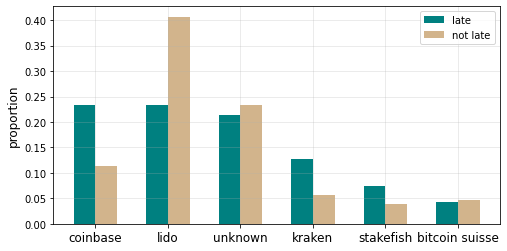

In [93]:
fig, ax = plt.subplots(figsize=(8,4))

ax.bar(np.arange(6)-0.15, lates, width=0.3, label='late', color='teal')
ax.bar(np.arange(6)+0.15, nonlates, width=0.3, label='not late', color='tan')

ax.set_xticks(np.arange(6))
ax.set_xticklabels(['coinbase', 'lido', 'unknown', 'kraken', 'stakefish', 'bitcoin suisse'], size=12)
ax.legend()
ax.set_ylabel('proportion', size=12)
plt.show()

'coinbase': 22,
 'lido': 22,
 'unknown': 20,
 'kraken': 12,
 'stakefish': 7,
 'bitcoin suisse': 4,

In [68]:
lateish_counts = {'coinbase': 22,
 'lido': 22,
 'unknown': 20,
 'kraken': 12,
 'stakefish': 7,
 'bitcoin suisse': 4,
 'huobi': 2,
 'stkr': 1,
 'rocketpool': 1,
 'poloniex': 1,
 'stakehound': 1,
 'staked.us': 1}

In [95]:
dict(sorted(stakers_count.items(), key=lambda item: item[1], reverse=True))

{'lido': 1050,
 'unknown': 603,
 'coinbase': 294,
 'kraken': 148,
 'bitcoin suisse': 123,
 'stakefish': 99,
 'staked.us': 76,
 'rocketpool': 36,
 'figment': 27,
 'huobi': 25,
 'frax finance': 23,
 'stakewise': 16,
 'stakehound': 14,
 'abyss finance': 11,
 'stkr': 9,
 'poloniex': 6,
 'bitstamp': 5,
 'wex exchange': 4,
 'cake defi': 3,
 'everstake pool': 3,
 'bitfinex': 2,
 'stakewise solos': 1,
 'sharedstake': 1,
 'blox staking': 1,
 'mintdice.com': 1}

In [97]:
relative = [22/(294+22), 22/(1050+22), 20/(603+20), 12/(148+12), 7/(7+99), 4/(4+123)]

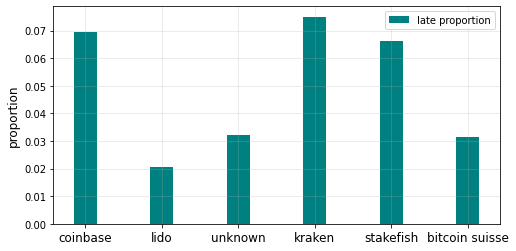

In [98]:
fig, ax = plt.subplots(figsize=(8,4))

ax.bar(np.arange(6), relative, width=0.3, label='late proportion', color='teal')

ax.set_xticks(np.arange(6))
ax.set_xticklabels(['coinbase', 'lido', 'unknown', 'kraken', 'stakefish', 'bitcoin suisse'], size=12)
ax.legend()
ax.set_ylabel('proportion', size=12)
plt.show()